In [7]:
# --- Import Required Libraries ---
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# --- Function to Calculate Black-Scholes Implied Volatility ---
def black_scholes_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma   2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def implied_volatility(S, K, T, r, market_price):
    def objective(sigma):
        return black_scholes_price(S, K, T, r, sigma) - market_price
    try:
        return brentq(objective, 0.01, 2.0)
    except ValueError:
        return np.nan

# --- Heston Model Simulation Function ---
def simulate_multiple_paths_heston(delta_t, r, kappa, theta, xi, rho, s_0, v_0, n_iterations, n_paths):
    times = np.linspace(0, n_iterations * delta_t, n_iterations + 1)

    cov_matrix = [[delta_t, rho * delta_t], [rho * delta_t, delta_t]]
    correlated_random_walks = np.random.multivariate_normal([0, 0], cov_matrix, (n_paths, n_iterations))

    dW_s, dW_v = correlated_random_walks[:, :, 0], correlated_random_walks[:, :, 1]

    prices, volatilities = np.zeros((n_paths, n_iterations + 1)), np.zeros((n_paths, n_iterations + 1))
    prices[:, 0], volatilities[:, 0] = s_0, v_0

    for i in range(1, n_iterations + 1):
        volatilities[:, i] = np.maximum(volatilities[:, i-1] + kappa * (theta - volatilities[:, i-1]) * delta_t
                                        + xi * np.sqrt(volatilities[:, i-1]) * dW_v[:, i-1], 0)

        prices[:, i] = prices[:, i-1] + prices[:, i-1] * (r * delta_t + np.sqrt(volatilities[:, i-1]) * dW_s[:, i-1])

    return times, prices

# --- Option Pricing Function ---
def option_price_calc(times, paths, T, t, r, K):
    time_position = np.argmin(np.abs(times - T))
    final_prices = paths[:, time_position]
    final_payoffs = np.maximum(final_prices - K, 0)
    return np.exp(-r * (T - t)) * np.mean(final_payoffs)

# --- Define Simulation Parameters ---
S0, r, T_max, n_iterations, n_paths = 100, 0.05, 1, 252, 10000
delta_t = T_max / n_iterations
strike_range = np.linspace(80, 120, 10)

# --- Fixed Baseline Parameters ---
baseline_params = {"kappa": 2.0, "theta": 0.04, "xi": 0.5, "rho": -0.7, "v0": 0.04}

# --- Function to Generate a Single IV and S(T) Plot for a Range of One Parameter ---
def generate_single_param_range_plots(param_name, param_values):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    plt.subplots_adjust(left=0.1, right=0.9, top=0.7, bottom=0.3, wspace=0.4)  # Creates space for explanations

    T_fixed = 1.0  # Fixed maturity of 1 year
    colors = ['blue', 'red', 'orange']

    # First subplot: Implied Volatility vs. Strike Price
    ax1 = axes[0]
    for idx, param_value in enumerate(param_values):
        params = baseline_params.copy()
        params[param_name] = param_value

        # Simulate Heston paths with modified parameter
        times, S_paths = simulate_multiple_paths_heston(
            delta_t, r,
            params["kappa"], params["theta"], params["xi"], params["rho"],
            S0, params["v0"], n_iterations, n_paths
        )

        # Compute IV for different strike prices at fixed T
        iv_curve = []
        for K in strike_range:
            option_price = option_price_calc(times, S_paths, T_fixed, 0, r, K)
            iv_curve.append(implied_volatility(S0, K, T_fixed, r, option_price))

        ax1.plot(strike_range, iv_curve, label=f"{param_name} = {param_value}", color=colors[idx])

    ax1.set_xlabel("Strike Price (K)")
    ax1.set_ylabel("Implied Volatility")
    ax1.set_title(f"Impact of {param_name} on Implied Volatility (T={T_fixed} year)")
    ax1.legend()
    ax1.grid(True)

    # Second subplot: Distribution of S(T)
    ax2 = axes[1]
    for idx, param_value in enumerate(param_values):
        params = baseline_params.copy()
        params[param_name] = param_value

        # Simulate stock paths
        times, S_paths = simulate_multiple_paths_heston(
            delta_t, r,
            params["kappa"], params["theta"], params["xi"], params["rho"],
            S0, params["v0"], n_iterations, n_paths
        )

        # Compute final stock prices
        final_prices = S_paths[:, -1]

        # Plot density histogram
        ax2.hist(final_prices, bins=50, alpha=0.5, density=True, color=colors[idx], label=f"{param_name} = {param_value}")

    ax2.set_xlabel("Final Stock Price (S(T))")
    ax2.set_ylabel("Probability Density")
    ax2.set_title(f"Distribution of S(T) for Varying {param_name}")
    ax2.legend()
    ax2.grid(True)

    plt.show()


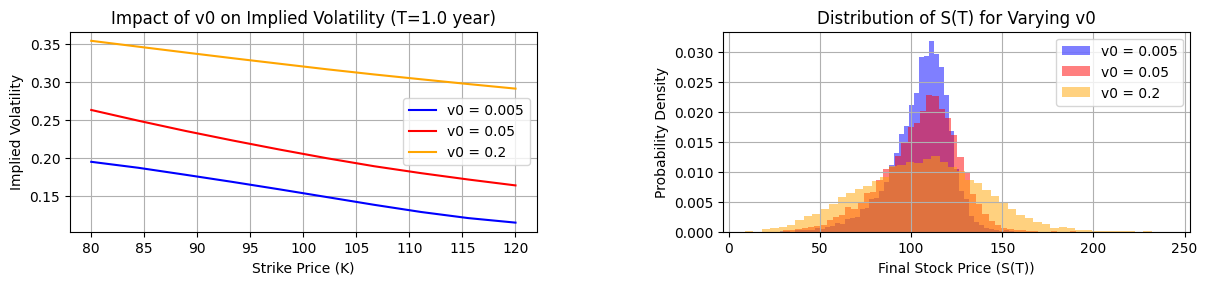

In [8]:
# --- Example Usage (Testing a Range of One Parameter) ---
generate_single_param_range_plots(param_name="v0", param_values=[0.005, 0.05, 0.2])


##  1️⃣ Initial Variance \( v_0 \)
###  IV vs. Strike Price (Left Plot)
-  Higher \( v_0 \) shifts the entire IV curve upward.   
- This makes options  more expensive  because traders expect  more stock price movement .  
- The IV curve’s  shape stays the same , but the  entire curve rises .

###  Final Stock Price Distribution \( S(T) \) (Right Plot)
-  Higher \( v_0 \) leads to a wider distribution.   
- The stock price has a  greater chance  of ending  far above or below  its starting point.  
- Lower \( v_0 \) means  tighter clustering  around the initial stock price.


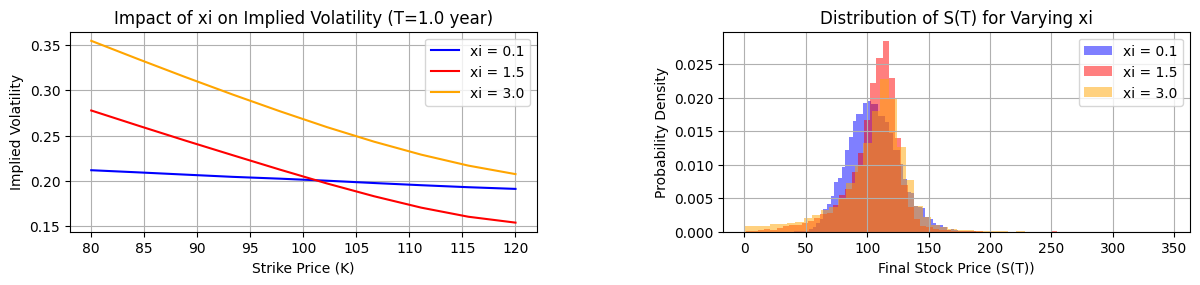

In [9]:
# --- Volatility of Volatility (xi) ---
generate_single_param_range_plots(param_name="xi", param_values=[0.1, 1.5, 3.0])

##  2️⃣ Volatility of Volatility \( $\xi$ \)
###  IV vs. Strike Price (Left Plot)
- Higher \( $\xi$ \) increases curvature, especially at deep ITM/OTM strikes.  
- A high \( $\xi$ \) means volatility itself changes unpredictably.  
- Deep OTM and ITM options become much more expensive due to wild price swings.

###  Final Stock Price Distribution \( S(T) \) (Right Plot)
- Higher \( $\xi$ \) leads to more extreme price movements.  
- The stock price distribution widens, creating fatter tails.  
- Low \( $\xi$ \) means price movements are more stable and *less extreme.


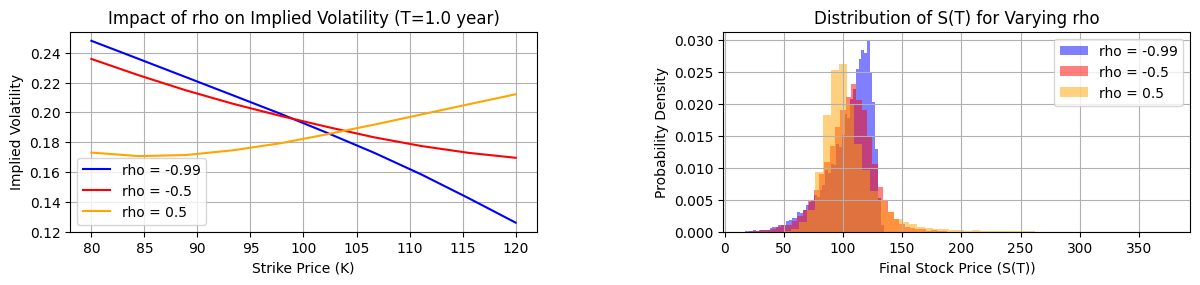

In [13]:
# --- Correlation (rho) ---
generate_single_param_range_plots(param_name="rho", param_values=[-0.99, -0.5, 0.5])


##  3️⃣ Correlation \( $\rho$ \)
###  IV vs. Strike Price (Left Plot)
-  More negative \( $\rho$ \) leads to a downward-sloping IV curve.   
- This means  low-strike (put) options are more expensive  than high-strike (call) options.  
- Traders expect  volatility to rise when the stock falls , increasing put prices.

###  Final Stock Price Distribution \( S(T) \) (Right Plot)
-  More negative \( $\rho$ \) makes crashes more likely.   
- The stock price distribution  becomes asymmetric , skewing toward  lower prices .  
- Positive \( $\rho$ \) (rare) would make  big rallies  more likely.


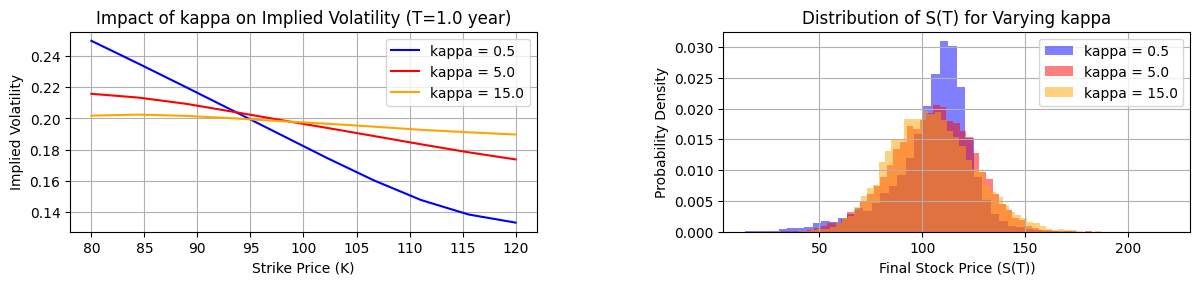

In [11]:

# --- Mean Reversion Speed (kappa) ---
generate_single_param_range_plots(param_name="kappa", param_values=[0.5, 5.0, 15.0])


##  4️⃣ Mean Reversion Speed \( $\kappa$ \)
###  IV vs. Strike Price (Left Plot)
-  Higher \( $\kappa$ \) flattens the IV curve.   
- This is because  volatility reverts back to normal quickly , reducing extreme IV spikes.  
- Lower \( $\kappa$ \) allows  volatility to stay high longer , so options remain expensive.

###  Final Stock Price Distribution \( S(T) \) (Right Plot)
-  Higher \( $\kappa$ \) leads to a tighter distribution  because volatility  reverts to the mean faster .  
- Lower \( $\kappa$ \) allows  volatility to persist , making extreme price movements  more common .


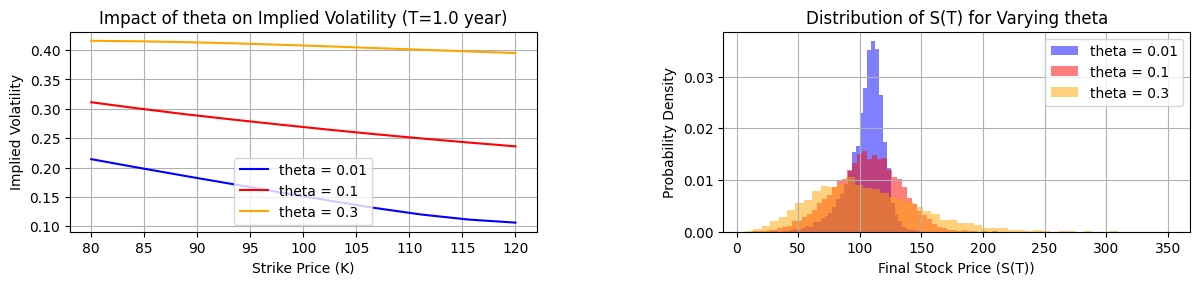

In [14]:
# --- Long-Run Variance (theta) ---
generate_single_param_range_plots(param_name="theta", param_values=[0.01, 0.1, 0.3])


##  5️⃣ Long-Run Variance \( $\theta$ \)
###  IV vs. Strike Price (Left Plot)
-  Higher \( $\theta$ \) raises IV across all strikes.   
- This happens because traders expect  high volatility to persist long-term .  
- The IV curve  remains the same shape  but shifts  higher .

###  Final Stock Price Distribution \( S(T) \) (Right Plot)
-  Higher \( $\theta$ \) leads to a wider distribution , meaning large price moves are  more common .  
- Low \( $\theta$ \) means the stock price remains  closer to its initial value .
